In [1]:
# Loading required packages
from fastai.text import *
np.random.seed(42)

In [ ]:
# Download the dataset and extract the files
# !cp /content/drive/'My Drive'/'Colab Notebooks'/translation/parallel.tgz .
# !tar xf parallel.tgz 

In [2]:
# Path to file
path = Path("./parallel/")

In [ ]:
# Loading the files - English words
# with open(path/'IITB.en-hi.en') as f: 
#   en = f.read().split('\n')

In [ ]:
# Hindi Words
# with open(path/'IITB.en-hi.hi') as f: 
#   hi = f.read().split('\n')

In [3]:
!cp /content/drive/'My Drive'/'Colab Notebooks'/translation/hindi_english_parallel.csv .

In [ ]:
# Creating a dataset out of the given sentences
# df = pd.DataFrame({'hindi': hi, 'english': en}, columns = ['hindi', 'english'])
# df.to_csv("hindi_english_parallel.csv", index=False)

In [49]:
df_samp = pd.read_csv("hindi_english_parallel.csv", low_memory=False)
df_samp.tail()

,hindi,english
1561836,स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...,स्पष्टीकरण.–जहां इस उपधारा के अधीन हानि और लाभ...
1561837,मैंने गौर किया है कि यह न केवल अपने महत्त्वपूर...,है। I note that this is a landmark meeting – n...
1561838,उन्होंने मेरे समक्ष जो प्रदर्शन किया उसमें से ...,है। In the presentations that they made before...
1561839,खाद्य और जल सुरक्षा; पर्यावरण की दृष्टि से वहन...,्त है। Issues such as food and water security;...
1561840,NaN,NaN


In [50]:
# Taking randomly 50000 datapoints from the complete dataset
# df = df_samp.iloc[np.random.choice(df_samp.shape[0], size=64, replace=False)].reset_index(drop=True)
df = df_samp.iloc[np.random.choice(df_samp.shape[0], size=50000, replace=False)].reset_index(drop=True)
del df_samp

In [51]:
df['hindi'].replace('nan', np.nan, inplace=True)
df['english'].replace('nan', np.nan, inplace=True)

In [52]:
df.dropna(subset=['hindi'], inplace=True)
df.dropna(subset=['english'], inplace=True)

In [53]:
df.reset_index(drop=True, inplace=True)
df.shape

(49807, 2)

In [54]:
df.tail()

,hindi,english
49802,और जब कोई मौज छाया-छत्रों की तरह उन्हें ढाँक ल...,"And when a wave covereth them like awnings, th..."
49803,हिन्दी रेडियो (रेडियो इरान),Hindi radio (Radio Iran)
49804,"और जब हमारे सामने ज़बरदस्त समस्याएं होती हैं,",And when we have overwhelming problems in fron...
49805,फालबैक कंसोल प्रारंभ नहीं कर सका,Can not start fallback console
49806,मगर सारे जहाँ का पालने वाला जिसने मुझे पैदा कि...,"Indeed, they are enemies to me, except the Lor..."


In [55]:
df['hindi'] = df['hindi'].apply(lambda x:str(x).lower())
df['english'] = df['english'].apply(lambda x:str(x).lower())

In [56]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [13]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [14]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [57]:
src = Seq2SeqTextList.from_df(df, path = path, cols='hindi').split_by_rand_pct(seed=42).label_from_df(cols='english', label_cls=TextList)

In [58]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

38.0

In [59]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

35.0

In [60]:
# Removing data with length greater than 30
src = src.filter_by_func(lambda x,y: len(x) > 40 or len(y) > 40)

In [61]:
len(src.train) + len(src.valid)

45164

In [64]:
data

Seq2SeqDataBunch;

Train: LabelList (36136 items)
x: Seq2SeqTextList
xxbos वे समाजवाद के निश्चित रूप से xxunk - xxunk बढ़ने मे विश्वास करते थे और xxunk कार्यवाहियों व xxunk विद्रोह के xxunk थे ।,xxbos समझना,xxbos xxunk उन्मूलन भारत सरकार का एक प्राथमिकता प्राप्त स्वास्थ्य लक्ष्य रहा है ।,xxbos इस प्रकार , भले ही पहले की घटना एक अनियमितता के रूप में मानी जा सकती है , लेकिन अधिनिर्णय पर हस्ताक्षर होने से वह सुधार गई थी .,xxbos महामहिम , मैं इस अवसर पर आपके व्यक्तिगत स्वास्थ्य और कुशलता तथा कोरिया गणराज्य की मित्र जनता की प्रगति और समृद्धि के लिए अपनी शुभकामनाएं प्रेषित करता हूं ।
y: TextList
xxbos they believed in inevitable but gradual progress towards socialism and xxunk violent activities and armed insurrection .,xxbos grasp,xxbos polio eradication has been a priority health objective of the government of india .,xxbos thus , even if the earlier incident could be regarded as an irregularity , the same stood xxunk by the signing of the award .,xxbos i take this opportunity to convey to

In [63]:
data = src.databunch(bs=32)
# data.save()
# data.show_batch()

In [20]:
data

Seq2SeqDataBunch;

Train: LabelList (52 items)
x: Seq2SeqTextList
xxbos xxunk का xxunk xxunk था xxunk,xxbos मैं xxunk xxunk कर xxunk xxunk ।,xxbos xxunk xxunk xxunk xxunk,xxbos xxunk,xxbos xxunk में xxunk xxunk xxunk xxunk में xxunk का xxunk है
y: TextList
xxbos xxunk was xxunk the xxunk ?,xxbos i have xxunk xxunk my xxunk .,xxbos xxunk xxunk xxunk xxunk,xxbos xxunk,xxbos a xxunk of xxunk in the xxunk xxunk xxunk to xxunk xxunk .
Path: parallel;

Valid: LabelList (9 items)
x: Seq2SeqTextList
xxbos xxunk ( xxunk ),xxbos xxunk xxunk xxunk xxunk से xxunk xxunk में xxunk xxunk xxunk कोई xxunk xxunk xxunk xxunk की xxunk xxunk xxunk xxunk xxunk ।,xxbos xxunk - xxunk,xxbos xxunk की xxunk xxunk xxunk से xxunk xxunk में है ।,xxbos xxunk xxunk xxunk xxunk से xxunk xxunk xxunk का एक xxunk हैं ।
y: TextList
xxbos xxunk,xxbos xxunk xxunk xxunk the xxunk xxunk xxunk xxunk , xxunk of xxunk xxunk xxunk xxunk xxunk xxunk .,xxbos xxunk,xxbos the xxunk xxunk is xxunk in the xxunk xxunk .,xxbos the xxunk 

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
!pip install fastText/.

In [ ]:
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz 
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.bin.gz  

--2020-07-24 15:02:55--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  10.5MB/s    in 7m 1s   

2020-07-24 15:09:57 (10.2 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]

--2020-07-24 15:09:59--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4371554972 (4.1G) [application/octet-stream]
Saving to: 

In [ ]:
# !gunzip cc.en.300.bin.gz
# !gunzip cc.hi.300.bin.gz

In [ ]:
# def create_emb(vecs, itos, em_sz=300, mult=1.):
#     emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
#     wgts = emb.weight.data
#     vec_dic = {w:vecs.get_word_vector(w) for w in vecs.get_words()}
#     miss = []
#     for i,w in enumerate(itos):
#         try: wgts[i] = tensor(vec_dic[w])
#         except: miss.append(w)
#     return emb

In [ ]:
# import fasttext as ft

In [ ]:
# hindi_vecs = ft.load_model("cc.hi.300.bin")
# emb_enc = create_emb(hindi_vecs, data.x.vocab.itos)
# del hindi_vecs
# english_vecs = ft.load_model("cc.en.300.bin")
# emb_dec = create_emb(english_vecs, data.y.vocab.itos)
# del english_vecs

In [ ]:
# torch.save(emb_enc, 'hindi_encoder.pth')
# torch.save(emb_dec, 'english_decoder.pth')
# !cp "english_decoder.pth" "/content/drive/My Drive/Colab Notebooks/translation/" 
# !cp "hindi_encoder.pth" "/content/drive/My Drive/Colab Notebooks/translation/" 

In [21]:
!cp "/content/drive/My Drive/Colab Notebooks/translation/english_decoder.pth"  .
!cp "/content/drive/My Drive/Colab Notebooks/translation/hindi_encoder.pth" .

In [22]:
emb_enc = torch.load('hindi_encoder.pth')
emb_dec = torch.load('english_decoder.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [23]:
emb_enc.weight.size(), emb_dec.weight.size()

(torch.Size([13464, 300]), torch.Size([12472, 300]))

In [39]:
xb,yb = next(iter(data.valid_dl))

In [40]:
xb.shape

torch.Size([9, 39])

In [ ]:
one_param().new_zeros(self.nl, bs, self.nh)

In [ ]:
xb.new_zeros(11).long()

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [45]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        # print(inp.shape)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        # print(emb.shape)
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        # print(h.shape)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        # print(self.emb_dec(dec_inp).shape)
        # print(emb.shape)
        outp, h = self.gru_dec(emb, h)
        # print(outp.shape)
        # print(outp[:,0].shape)
        outp = self.out(self.out_drop(outp[:,0]))
        # print(outp.shape)
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        # print(inp.new_zeros(bs).long().shape)
        # print(dec_inp.shape)
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            # print(outp.max(1)[1])
            # Gives max value in each row and [0] stores individual max values and [1] returns its dimensions
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        # print(torch.stack(res, dim=1).shape)
        # print(len(res))
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): 
      # print(one_param(self).new_zeros(self.nl, bs, self.nh))
      # here one_param is used so that we can get an initialization on the same device and have the same dtype
      return one_param(self).new_zeros(self.nl, bs, self.nh)

In [44]:
test = Learner(data, Seq2SeqRNN(emb_enc, emb_dec, 256, 40), loss_func=seq2seq_loss)
test.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,9.826847,11.044992,00:00


torch.Size([32, 40, 12472])
torch.Size([9, 40, 12472])


In [33]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, 256, 40)

In [ ]:
rnn

Seq2SeqRNN(
  (emb_enc): Embedding(13464, 300, padding_idx=1)
  (emb_enc_drop): Dropout(p=0.15, inplace=False)
  (gru_enc): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.25)
  (out_enc): Linear(in_features=256, out_features=300, bias=False)
  (emb_dec): Embedding(12472, 300, padding_idx=1)
  (gru_dec): GRU(300, 300, num_layers=2, batch_first=True, dropout=0.1)
  (out_drop): Dropout(p=0.35, inplace=False)
  (out): Linear(in_features=300, out_features=12472, bias=True)
)

In [ ]:
len(xb[1])

40

In [28]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [ ]:
learn = Learner(data, rnn, loss_func=seq2seq_loss)

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


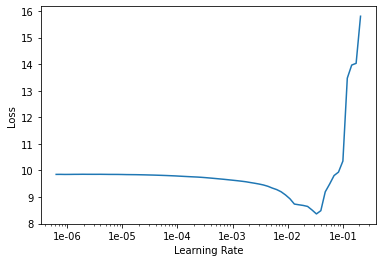

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,time
0,10.267066,9.286656,00:00


torch.Size([2, 32, 256])
torch.Size([2, 11, 256])


In [30]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

In [68]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        # print(last_output.shape)
        last_output = last_output.argmax(dim=-1)
        # print(last_output.shape)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

In [69]:
learn = Learner(data, rnn, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))])
# learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


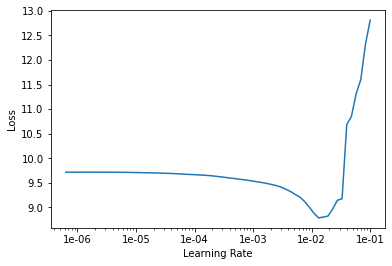

In [66]:
learn.lr_find()
learn.recorder.plot()

In [70]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,5.464280,6.066158,0.273685,0.141458,00:51
1,5.630243,6.478178,0.233180,0.088482,00:45
2,5.303527,6.146626,0.254848,0.121807,00:49
3,5.110715,5.939700,0.272344,0.135777,00:50
4,4.857590,5.764065,0.289263,0.152348,00:53
5,4.379004,5.492383,0.314128,0.158761,00:52
6,4.134423,5.375343,0.324418,0.182606,00:55
7,3.876650,5.339628,0.329971,0.178107,00:58
8,3.567559,5.076573,0.352458,0.197515,00:59
9,3.611239,5.080520,0.353035,0.197648,00:58


In [73]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,3.518303,5.027390,0.359113,0.204722,00:57
1,3.756623,5.770763,0.290884,0.155512,00:57
2,4.077001,5.303182,0.330484,0.192094,00:58
3,3.976252,5.597125,0.301939,0.168562,00:55
4,3.569070,5.380373,0.326454,0.191369,00:59
5,3.267044,4.912023,0.369354,0.213985,00:59
6,2.962853,4.699184,0.389847,0.226710,00:58
7,2.741320,4.581233,0.400683,0.235644,01:00
8,2.492210,4.526192,0.409176,0.239456,01:02
9,2.722174,4.536026,0.410049,0.241336,00:59


In [75]:
learn.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.671583,4.536010,0.406401,0.243082,01:01
1,3.115368,4.838090,0.378077,0.226145,01:01
2,2.888254,5.382823,0.330426,0.189427,00:58
3,2.660446,4.703212,0.391786,0.230311,00:59
4,2.663414,4.526934,0.412402,0.241071,01:03
5,2.351074,4.484652,0.419261,0.246558,01:03


learn

In [88]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [89]:
inputs, targets, outputs = get_predictions(learn)

RuntimeError: ignored

In [91]:
class TeacherForcing(LearnerCallback):
    
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

In [92]:
class Seq2SeqRNN_tf(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        self.pr_force = 0.
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
            
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [ ]:
rnn_tf = Seq2SeqRNN_tf(emb_enc, emb_dec, 256, 40)

learn = Learner(data, rnn_tf, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
               callback_fns=partial(TeacherForcing, end_epoch=3))

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


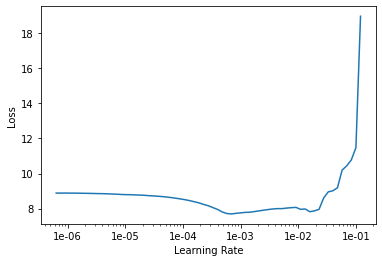

In [94]:
learn.lr_find()
learn.recorder.plot()

In [96]:
learn.fit_one_cycle(25, 5e-4)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,2.694495,5.155987,0.362187,0.231280,01:01
1,2.814102,4.775227,0.391417,0.255450,01:02
2,3.099578,5.135408,0.349859,0.220329,00:58
3,3.290375,5.062903,0.352627,0.210922,00:58
4,3.292368,5.131154,0.349117,0.209748,00:59
5,3.307874,4.537208,0.402555,0.234175,00:59
6,3.107181,4.874965,0.373747,0.225275,01:00
7,3.063493,4.584393,0.396856,0.222589,00:58
8,2.903768,4.725175,0.387627,0.232554,00:59
9,2.713431,4.692897,0.392390,0.228807,00:59
